In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Расчет ожидаемой эффективности от модели 

In [30]:
# используем данные с портала "Работа в России" за 2015-2020 гг.

cv_train = pd.read_csv('train.csv', sep=';')
cv_train = cv_train[['id', 'region', 'modification_date']]
cv_test = pd.read_csv('test.csv', sep=';')
cv_test = cv_test[['id', 'region', 'modification_date']]

cv = pd.concat([cv_train, cv_test])
cv.modification_date = cv.modification_date.map(lambda x: pd.to_datetime(x, errors="coerce")).values
cv.head()

c:\envs\kate\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,region,modification_date
0,0,Тульская область,2020-05-08
1,1,Алтайский край,2020-10-27
2,3,Ульяновская область,2020-02-04
3,4,Свердловская область,2020-09-20
4,5,Иркутская область,2020-09-09


In [31]:
cv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437529 entries, 0 to 131258
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 437529 non-null  int64         
 1   region             437512 non-null  object        
 2   modification_date  437519 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 13.4+ MB


In [34]:
# данные о последнем месте работы соискателем (дата увольнения)

employements = pd.read_csv('employements.csv', sep=';')
employements = employements[['id', 'finish_date']]
employements.finish_date = employements.finish_date.map(lambda x: pd.to_datetime(x, errors="coerce")).values
employements.head()

,id,finish_date
0,0,2020-04-01
1,1,NaT
2,2,2014-07-01
3,3,NaT
4,4,2013-01-01


In [35]:
employements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343328 entries, 0 to 343327
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           343328 non-null  int64         
 1   finish_date  294424 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.2 MB


In [38]:
# если finish_date на последнем месте работы не заполнена, то, скорее всего, имеем дело с тем, кто безработным не является - 
# убираем такие наблюдеия

data = cv.merge(employements, how='left').dropna()

<AxesSubplot:>

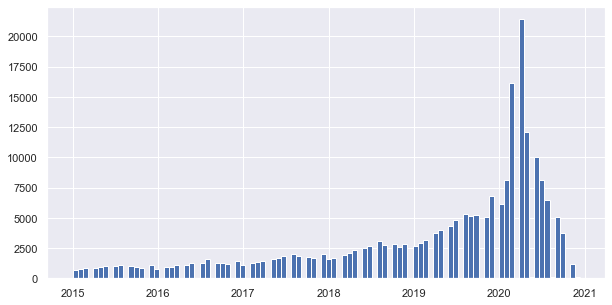

In [55]:
# присутствуют некорректно заполненные даты окончания работы

# удалим все те наблюдения, где дата окончания занятости > 2020 года

data = data[data.finish_date <= '2021-01-01']

# в качестве нижней границы возьмем 2015 год

data = data[data.finish_date >= '2015-01-01']

sns.set(rc={'figure.figsize' : (10, 5)})
data.finish_date.hist(bins=100)

In [54]:
# полученное число соискателей принимается за верхнюю границу числа
# зарегистрированных безработных на платформе с 2015 по 2020 год 

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225702 entries, 0 to 437527
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 225702 non-null  int64         
 1   region             225702 non-null  object        
 2   modification_date  225702 non-null  datetime64[ns]
 3   finish_date        225702 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 8.6+ MB


In [58]:
# предполагаем, что modification_date находится ближе всего к моменту приглашения соискателя на работу (нижняя граница)

# рассчитаем медианное время поиска соискателем работы

data['time'] = data.modification_date - data.finish_date

In [66]:
data['time'] = data.time.dt.days

In [70]:
# ~ 9 месяцев

data.time.median()/30

8.6

In [79]:
# рассчитаем коридор для суммы выплат пособий по безработице, которую можно сэкономить, если бы удалось сократить 
# средний срок поиска работы соискателями на 1 месяц

# (расчеты ориентированы на ноябрь 2020 года)

data = data.loc[(data.modification_date < '2020-12-01') & (data.modification_date >= '2020-11-01'), ['region']]
unemployment_benefit = pd.read_csv(r'размер пособия по безработице.csv', sep=';', decimal=',')
unemployment_benefit[(unemployment_benefit.Год == 2020) & \
                     (unemployment_benefit.Месяц == 11)]

,Год,Квартал,Месяц,Минимальный размер пособия,Максимальный размер пособия
130,2020,4,11,1500,12130


In [80]:
data['Минимальный_размер_пособия'] = 1500
data['Максимальный_размер_пособия'] = 12130

In [86]:
regional_coefficients = pd.read_csv(r'региональные коэффициенты.csv', sep=';', decimal=',')
regional_coefficients = regional_coefficients.rename({
    'Минимальный коэффициент' : 'Минимальный_коэффициент',
    'Максимальный коэффициент' : 'Максимальный_коэффициент'
}, axis=1).sort_values('Минимальный_коэффициент')

In [87]:
data

,region,Минимальный_размер_пособия,Максимальный_размер_пособия
15,Новосибирская область,1500,12130
36,Амурская область,1500,12130
42,Брянская область,1500,12130
45,Пермский край,1500,12130
71,Тверская область,1500,12130
...,...,...,...
437198,Ханты-Мансийский автономный округ - Югра,1500,12130
437393,Волгоградская область,1500,12130
437413,Московская область,1500,12130
437478,Новосибирская область,1500,12130


In [90]:
data = data.merge(regional_coefficients, how='left', left_on='region', right_on='Субъект')

In [92]:
data['Коридор_минимум'] = data['Минимальный_размер_пособия'] * data['Минимальный_коэффициент']
data['Коридор_максимум'] = data['Максимальный_размер_пособия'] * data['Максимальный_коэффициент']

In [95]:
data[['Коридор_минимум', 'Коридор_максимум']].sum()

Коридор_минимум      32236200.0
Коридор_максимум    284626204.5
dtype: float64

Таким образом, если применение модели позволит сократить время поиска работы на 1 месяц, затраты государства на выплаты пособий по безработице сократятся на 32-284 млн руб. в условиях пандемии.